# What is Perceived Information? 
## Companion notebook

This is a companion notebook for the tutorial on perceived information. For our traces, we have cloned the TinyAES implementation from this repository https://github.com/kokke/tiny-AES-c/ and we loaded the firmware on an ARM Cortex M0, which was modified for the collection of traces.
If you want to follow along, download the set of traces from here https://zenodo.org/record/4742593#.YK8drmYzYUo.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
from scipy.stats import norm, entropy
import scipy.stats as stats
import math
from pylab import *
from tqdm import tqdm #progress bar for visualization of progress

 
- `trace_set.npy` , is the trace set file, with a given `number_of_traces`, captured from the oscilloscope. 
It captures roughly the first round of execution (it contains samples $10000-25000$ from the overview trace). Each trace has `number_of_samples` samples. 
- `plaintex.txt`, contains the plaintexts which are encrypted by the algorithm. One plaintext corresponds to one trace (they are provided in order).

Let's load these datafiles and figure out how many traces we have in the trace set file and how many samples each trace has. 


In [2]:
traces = np.load("trace_set_10k.npy")

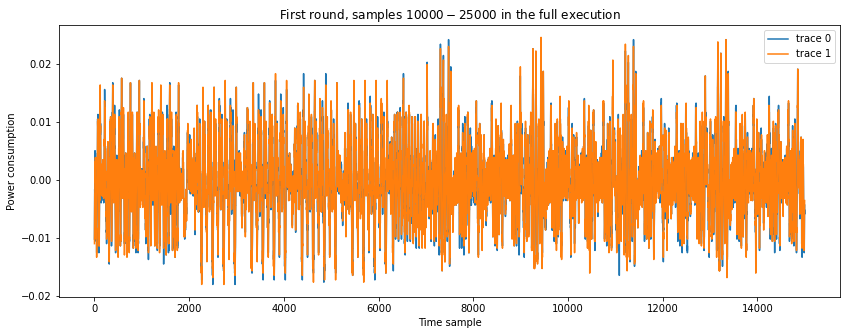

In [3]:
plt.figure(figsize=(14,5))
plt.plot(traces[0,:], label='trace 0')
plt.plot(traces[1,:], label='trace 1')
plt.title('First round, samples $10000-25000$ in the full execution')
plt.xlabel('Time sample')
plt.ylabel('Power consumption')
plt.legend()
plt.savefig('first_round.png')


In [4]:
number_of_traces=len(traces)
print('Number of traces:', number_of_traces)
number_of_samples=len(traces[0])
print('Number of samples:', number_of_samples)

Number of traces: 10000
Number of samples: 15000


To refresh your memory on the use of the S-box, please refer to this article https://en.wikipedia.org/wiki/Rijndael_S-box. 

In [5]:
sbox = [0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, 0x67,
            0x2b, 0xfe, 0xd7, 0xab, 0x76, 0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59,
            0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0, 0xb7,
            0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc, 0x34, 0xa5, 0xe5, 0xf1,
            0x71, 0xd8, 0x31, 0x15, 0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05,
            0x9a, 0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75, 0x09, 0x83,
            0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29,
            0xe3, 0x2f, 0x84, 0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b,
            0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf, 0xd0, 0xef, 0xaa,
            0xfb, 0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c,
            0x9f, 0xa8, 0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5, 0xbc,
            0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2, 0xcd, 0x0c, 0x13, 0xec,
            0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19,
            0x73, 0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88, 0x46, 0xee,
            0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb, 0xe0, 0x32, 0x3a, 0x0a, 0x49,
            0x06, 0x24, 0x5c, 0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
            0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4,
            0xea, 0x65, 0x7a, 0xae, 0x08, 0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6,
            0xb4, 0xc6, 0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a, 0x70,
            0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9,
            0x86, 0xc1, 0x1d, 0x9e, 0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e,
            0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf, 0x8c, 0xa1,
            0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 0x2d, 0x0f, 0xb0,
            0x54, 0xbb, 0x16]

Read the plaintext file, we need this to compute the LSB leakage model. 

In [6]:
plaintext = np.zeros(shape=(number_of_traces, 16))

filename="plaintext_new.txt"
with open(filename) as f:
    content = f.readlines()

content = [x.strip() for x in content] 
plaintext = np.array([bytearray.fromhex(c) for c in content])


## Preparations

The functions used in this part of the notebook are explained in this [interactive notebook](https://github.com/ileanabuhan/Tutorial-on-entropies/blob/master/Mutual%20Entropy%20for%20SCA%20%20with%20bounds.ipynb). 

In [7]:
def prepare_data(trace_set, labels_set):
    """
    trace_set = a set of traces
    labels_set = the leakage model of the target intermediate value
    
    returns a dictionary of the form
       'label_value': list of traces associated with 'label_value'
    """
   
    labels=np.unique(labels_set)
    #initialize the dictionary
    d={}
    for i in labels:
         d[i]=[]
    for count, label in enumerate(labels_set):
        d[label].append(trace_set[count])
    return d


def estimate_normal_parameters(s_data, train_labels):
  """
  s_data = the set of sample in the format output by prepare_data function
  labels_set = a set of labels of the same lenght as the set of samples
  returns the set of param for the estimated model
  """
  #s=prepare_data(train_samples, train_labels, target_sample)
  labels=np.unique(train_labels)
  esti_models = [None for label in labels]
  for label in labels:
      esti_models[label] = [np.mean(s_data[label]),np.std(s_data[label])]
  return esti_models

def information(p_k,data,model):
    """
    implements I(K;L)

    p_k = the distribution of the sensitive variable K
    data = the samples we 'measured'. It its the n^k_p samples from p(l|k)
    model = the estimated distribution of the data \hat{p}(l|k).

    returns an estimated of mutual information
    """
    N_k = len(p_k)              #N_k is the number of possible values for $K$
    acc = entropy(p_k,base=2)   #we initialize the value with H(K)
    for k in range(N_k):
        l = data[k]
        p_l_k = np.zeros((N_k,len(l)))
        for k_star in range(N_k):
            p_l_k[k_star,:] = ss.norm.pdf(l,*(model[k_star]))
        p_l=np.sum(p_k*(p_l_k).T,axis=1)
        p_k_l =  p_k[k]*p_l_k[k,:]/ p_l
        acc += p_k[k] * np.mean(np.log2(p_k_l))
    return acc


## Lets pick our target intermediate value

Some definitions of variables to help us decypher the code:

- `TARGET_BYTE`, the attack is performed using divide-and-conquer approach, one byte at a time. This variable represents the key byte we are recovering. 
- `CORRECT_BYTE_VALUE`, the value of the byte we are targeting/profiling. 

In [8]:
TARGET_BYTE=0
CORRECT_BYTE_VALUE=0xCA

##  Hypothetical Information

In [9]:
sample_list= list(range(2150,2450,1))
NUMBER_CLASSES=256
label_ID=[] #the label to divide the data
for i in tqdm(range(0, number_of_traces)):
    label_ID.append(sbox[CORRECT_BYTE_VALUE ^ int(plaintext[i][TARGET_BYTE])])   
    
p_k_ID= np.ones(NUMBER_CLASSES, dtype=np.float64)
freq_labels=pd.Series(label_ID).value_counts()
for i in range(NUMBER_CLASSES):
    p_k_ID[i]=freq_labels[i]/number_of_traces

HI=[]
for s in tqdm(sample_list):
    target_sample=traces[:,s]
    grouped_traces=prepare_data(target_sample, label_ID)
    esti_models = estimate_normal_parameters(grouped_traces, label_ID)
    HI.append(information(p_k_ID,grouped_traces,esti_models))

100%|██████████| 300/300 [36:36<00:00,  7.32s/it]   


<ipython-input-10-0cf428b662a2>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(t)


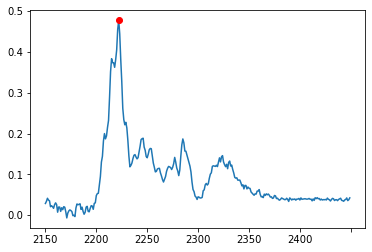

In [10]:
fig, ax = plt.subplots()
fig.canvas.draw()
t = arange(2100, 2450, 50)
#ax.plot(HI[2150:2450])
ax.plot(HI)
ax.plot(72,HI[72],'ro')
ax.set_xticklabels(t)
fig.savefig('HI_zoom')
plt.show()

## Adding low noise to the original traces

In [11]:
def generate_noise(var,number_elements):
    return np.random.normal(0,var,number_elements)


## Perceived Information for low noise

In [12]:
sim_traces_low=traces
var=0.0008
for i in tqdm(range(0, number_of_traces)):
    sim_traces_low[i,:]+=generate_noise(var, number_of_samples)

100%|██████████| 10000/10000 [00:06<00:00, 1644.41it/s]


In [13]:
sample_list= list(range(2150,2450,1))
PI_low=[]
for s in tqdm(sample_list):
    target_sample =traces[:,s]
    target_sample_sim =sim_traces_low[:,s]
    
    grouped_traces=prepare_data(target_sample, label_ID)
    esti_models = estimate_normal_parameters(grouped_traces, label_ID)
    
    grouped_traces_sim=prepare_data(target_sample_sim, label_ID)
    PI_low.append(information(p_k_ID,grouped_traces_sim,esti_models))


100%|██████████| 300/300 [26:43<00:00,  5.35s/it]


<ipython-input-20-749364fe6366>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(t)


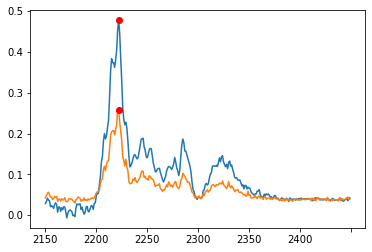

In [20]:
fig, ax = plt.subplots()
fig.canvas.draw()
t = arange(2100, 2450, 50)
#ax.plot(MI_ID[2150:2400])
ax.plot(HI)
ax.plot(PI_low)
ax.plot(72,HI[72],'ro')
ax.plot(72,PI_low[72],'ro')
ax.set_xticklabels(t)
fig.savefig('HI_PI_low_noise')
plt.show()


## Adding high noise

In [16]:
sim_traces_high=traces
var=0.003
for i in tqdm(range(0, number_of_traces)):
    sim_traces_high[i,:]+=generate_noise(var, number_of_samples)



100%|██████████| 10000/10000 [00:04<00:00, 2114.45it/s]


## Perceived Information for high noise

In [17]:
PI_high=[]

for s in tqdm(sample_list):
    target_sample=traces[:,s]
    target_sample_sim=sim_traces_high[:,s]
    grouped_traces_ID=prepare_data(target_sample, label_ID)
    grouped_traces_sim=prepare_data(target_sample_sim, label_ID)
    esti_models_ID = estimate_normal_parameters(grouped_traces_ID, label_ID)
    PI_high.append(information(p_k_ID,grouped_traces_sim,esti_models_ID))

100%|██████████| 300/300 [26:46<00:00,  5.35s/it]


<ipython-input-18-0bde93d7df39>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(t)


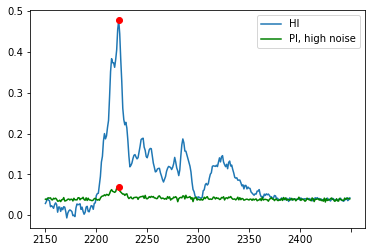

In [18]:
fig, ax = plt.subplots()
fig.canvas.draw()
t = arange(2100, 2450, 50)
ax.plot(HI,label='HI')
ax.plot(PI_high,color='green', label='PI, high noise')
ax.plot(72,HI[72],'ro')
ax.plot(72,PI_high[72],'ro')
ax.set_xticklabels(t)
plt.legend()
plt.show()